In [ ]:
#FilterImages

import os
import cv2
import numpy as np
from PIL import Image, ImageStat
from shutil import copyfile

# Create directories for input and output
input_folder = "train_images"         # Folder to extract images to
output_folder = "test_images"         # Folder to save processed images

os.makedirs(input_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

# Calculate brightness
def calculate_brightness(image):
    image = Image.fromarray(image)
    stat = ImageStat.Stat(image)
    return stat.mean[0]

# Calculate contrast
def calculate_contrast(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray.std()

# Function to calculate sharpness
def calculate_sharpness(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(image, cv2.CV_64F).var()
    return laplacian

# Quality thresholds for OCR readiness
BRIGHTNESS_THRESHOLD = 50
CONTRAST_THRESHOLD = 20
SHARPNESS_THRESHOLD = 100

# Function to evaluate image quality
def evaluate_image_quality(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read the image at {image_path}. Ensure it is a valid image file.")
    brightness = calculate_brightness(image)
    contrast = calculate_contrast(image)
    sharpness = calculate_sharpness(image)
    return brightness, contrast, sharpness

# Processing images
def process_images(input_folder, output_folder):
    results = []
    for image_name in os.listdir(input_folder):
        image_path = os.path.join(input_folder, image_name)
        if os.path.isfile(image_path):
            try:
                # Evaluate image
                brightness, contrast, sharpness = evaluate_image_quality(image_path)
                score = (brightness >= BRIGHTNESS_THRESHOLD and
                         contrast >= CONTRAST_THRESHOLD and
                         sharpness >= SHARPNESS_THRESHOLD)
                results.append((image_name, brightness, contrast, sharpness, score))
                # Save the image to output folder
                if score:
                    output_path = os.path.join(output_folder, image_name)
                    copyfile(image_path, output_path)
            except ValueError as e:
                # Log and skip invalid files
                print(e)
    return results

# Running  process
image_quality_results = process_images(input_folder, output_folder)

# Display results
for result in image_quality_results:
    print(f"Image: {result[0]}, Brightness: {result[1]:.2f}, Contrast: {result[2]:.2f}, Sharpness: {result[3]:.2f}, OCR Ready: {result[4]}")


In [ ]:
#PreProcess Images

import os
import cv2
import numpy as np
from scipy.ndimage import interpolation as inter

# Define input and output folders
input_folder = 'test_images'
output_folder = 'output_images'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

def preprocess_image(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur for noise reduction
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # pply Otsu's Thresholding for binarization
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Deskew the image
    coords = np.column_stack(np.where(binary > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Rotate the image to deskew
    (h, w) = binary.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed = cv2.warpAffine(binary, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Sharpen the image
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(deskewed, -1, kernel)

    # Save preprocessed image
    cv2.imwrite(output_path, sharpened)

# Iterate over all images in the input folder
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        preprocess_image(input_path, output_path)

print(f"Preprocessing complete. Preprocessed images are saved in '{output_folder}'.")


Preprocessing complete. Preprocessed images are saved in 'output_images'.


EDA results saved to eda_results.csv
Summary Statistics:
         Brightness      Contrast     Sharpness
count  19851.000000  19851.000000  19851.000000
mean     126.450198    117.093729   6109.175746
std       48.176934     13.809562   3656.923994
min        0.784935      1.863178     39.530719
25%       91.611524    113.326788   3605.060626
50%      123.884494    122.629250   5397.496080
75%      160.225494    126.317176   7762.568849
max      254.985037    127.487515  80042.355850


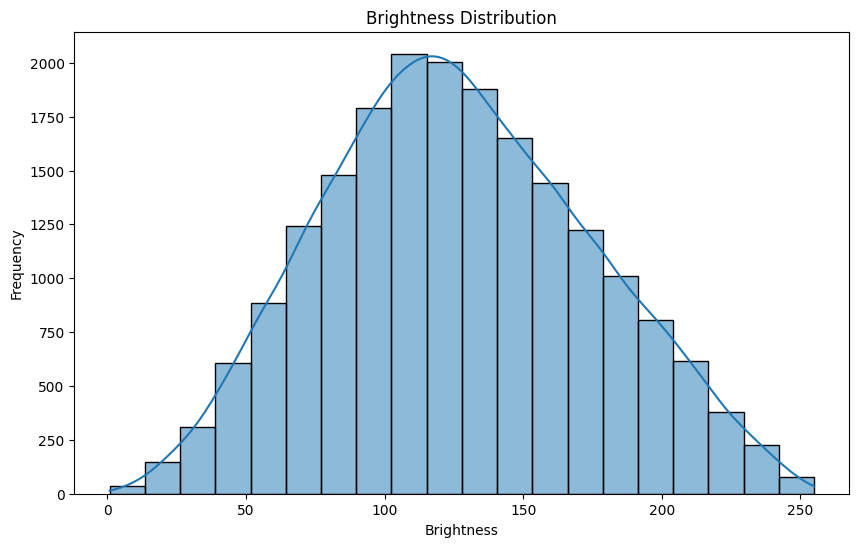

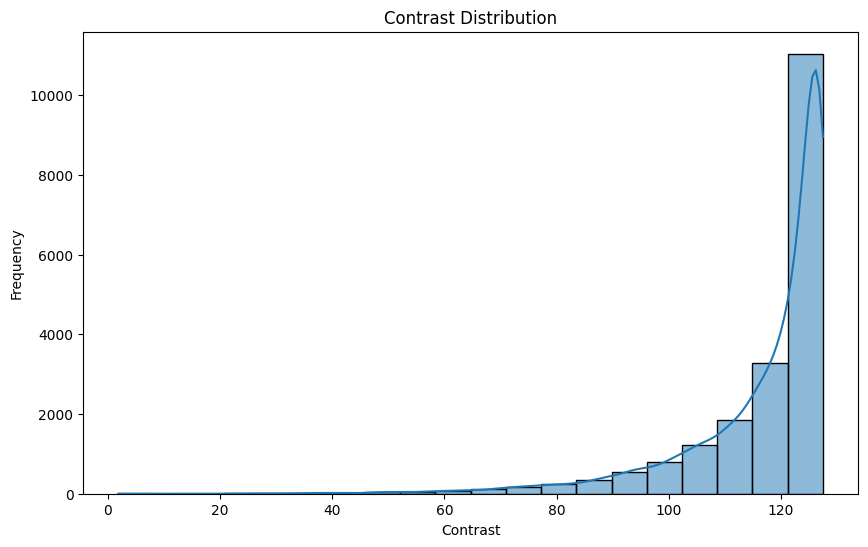

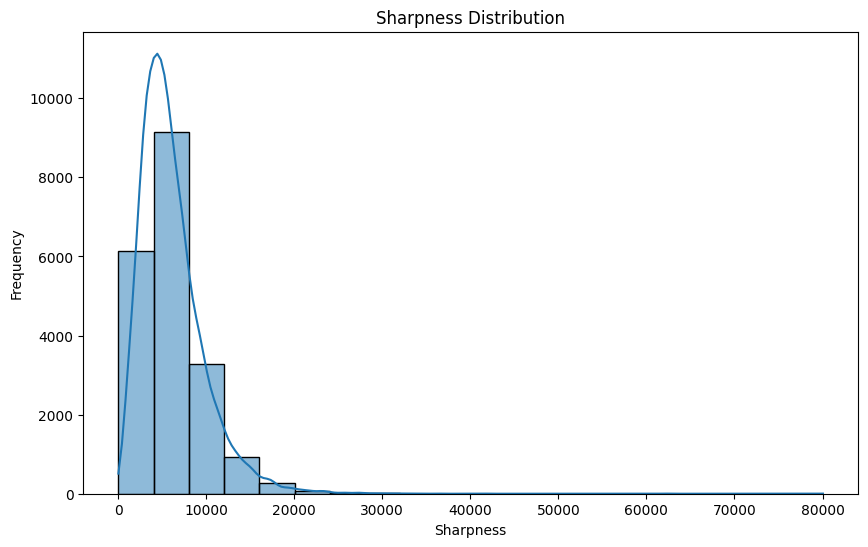

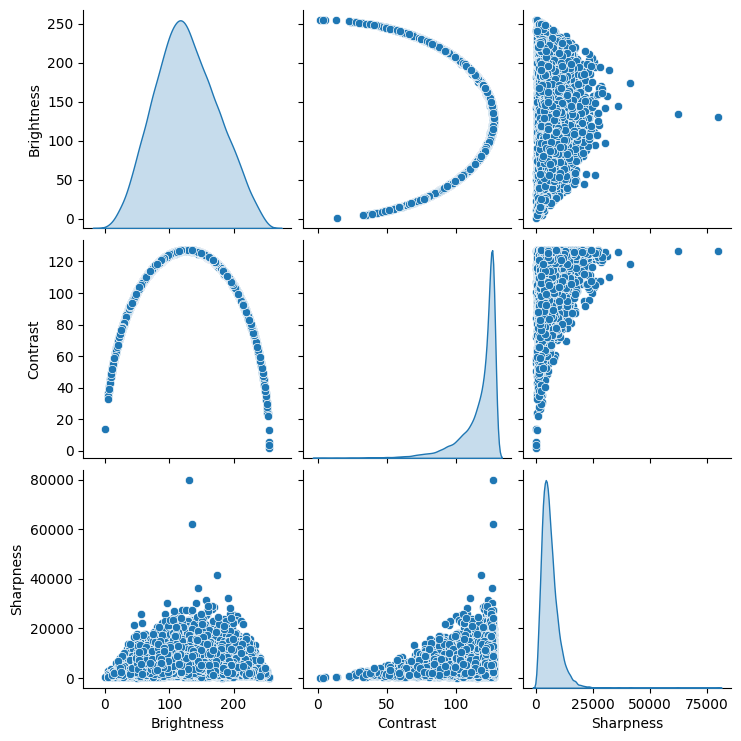

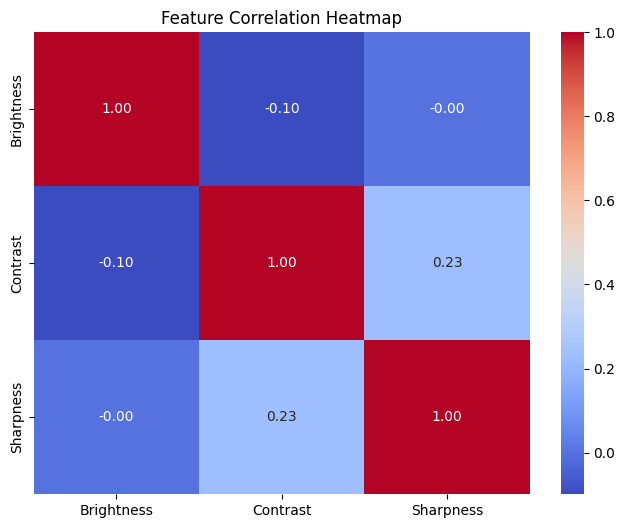

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageStat

# Paths
extracted_folder = "preprocessed_images/output_images"  # Updated to the correct folder containing images
output_csv = "eda_results.csv"  # Output file for saving results

# Helper Functions
def calculate_brightness(image):
    """Calculate brightness of an image."""
    image = Image.fromarray(image)
    stat = ImageStat.Stat(image)
    return stat.mean[0]

def calculate_contrast(image):
    """Calculate contrast of an image."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray.std()

def calculate_sharpness(image):
    """Calculate sharpness of an image."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian

# EDA: Process Images and Extract Features
def process_images(folder):
    """Process images and extract brightness, contrast, and sharpness features."""
    data = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')

    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)

        # Skip non-image files
        if not image_name.lower().endswith(valid_extensions):
            print(f"Skipping non-image file: {image_name}")
            continue

        # Read image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Unreadable image file: {image_name}")
            continue

        # Extract features
        try:
            brightness = calculate_brightness(image)
            contrast = calculate_contrast(image)
            sharpness = calculate_sharpness(image)
            data.append({"Image": image_name, "Brightness": brightness, "Contrast": contrast, "Sharpness": sharpness})
        except Exception as e:
            print(f"Error processing image {image_name}: {e}")

    return pd.DataFrame(data)

# Process Images and Save Results
df = process_images(extracted_folder)

if not df.empty:
    # Save results to CSV
    df.to_csv(output_csv, index=False)
    print(f"EDA results saved to {output_csv}")

    # Summary Statistics
    print("Summary Statistics:")
    print(df.describe())

    # Visualizations

    # Brightness Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df["Brightness"], bins=20, kde=True)
    plt.title("Brightness Distribution")
    plt.xlabel("Brightness")
    plt.ylabel("Frequency")
    plt.show()

    # Contrast Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df["Contrast"], bins=20, kde=True)
    plt.title("Contrast Distribution")
    plt.xlabel("Contrast")
    plt.ylabel("Frequency")
    plt.show()

    # Sharpness Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df["Sharpness"], bins=20, kde=True)
    plt.title("Sharpness Distribution")
    plt.xlabel("Sharpness")
    plt.ylabel("Frequency")
    plt.show()

    # Pairplot for Feature Relationships
    sns.pairplot(df, vars=["Brightness", "Contrast", "Sharpness"], diag_kind="kde")
    plt.show()

    # Correlation Heatmap
    plt.figure(figsize=(8, 6))
    numeric_columns = df.select_dtypes(include=[np.number])  # Select only numeric columns
    sns.heatmap(numeric_columns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()
else:
    print("No valid images were processed. Ensure the folder contains readable image files.")
